### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

<Figure size 1400x800 with 0 Axes>

Training data (590540, 434)
Testing data (506691, 433)
20663 569877
0.03625870143908247
(590540, 3)
(506691, 2)
(506691, 2)


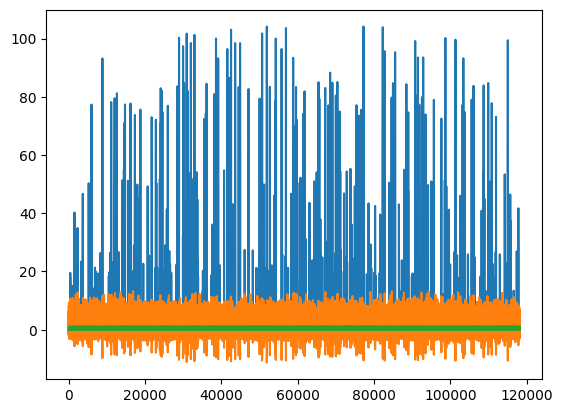

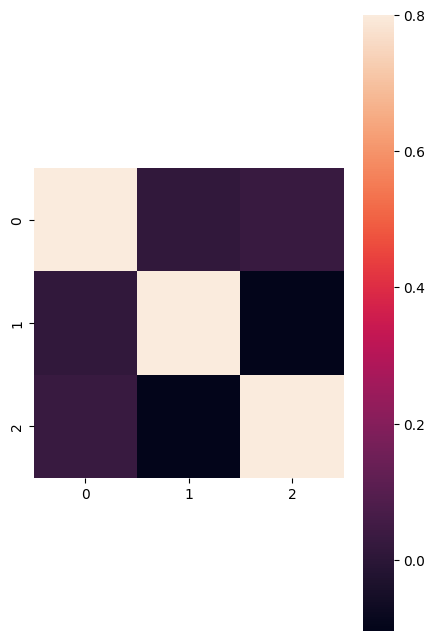

In [1]:
%run dataSampling.ipynb

In [2]:
#Create independent and Dependent Features
state = np.random.RandomState(42)
X = train_Data.drop('isFraud',axis=1)                
y = train_Data['isFraud']                 
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))

print(X.shape)
print(y.shape)


(590540, 28)
(590540,)


3 ML Algorithms-
Isolation Forest:  Isolation Forest is an unsupervised anomaly detection algorithm that identifies outliers in a dataset by randomly partitioning the data points and isolating anomalies with fewer partitions. It measures the average path length to isolate an observation and uses this as a scoring function to identify anomalies with shorter paths as outliers.

Local Outlier Factor (LOF): LOF is an unsupervised outlier detection method that measures the local density deviation of a data point compared to its neighbors. It assigns an anomaly score based on the ratio of the local density of a point to that of its neighbors, identifying points with significantly lower density as outliers.

One-Class SVM: One-Class SVM is a type of Support Vector Machine used for novelty detection, where it aims to model the distribution of normal data points and classify any new points that deviate significantly from the model as anomalies.


In [3]:

fraud=train_Data[train_Data['isFraud']==1]
valid=train_Data[train_Data['isFraud']==0]
print(len(fraud),len(valid))
outlier_fraction = len(fraud)/float(len(valid))
print(outlier_fraction)

20663 569877
0.03625870143908247


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
X_train=X_train.iloc[:50000]
y_train=y_train.iloc[:50000]
X_test=X_test.iloc[:50000]
y_test=y_test.iloc[:50000]

In [6]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, classification_report

# Define the outlier detection models
classifiers = {
    "Isolation Forest": IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', novelty=False, p=2),
    "One Class SVM": OneClassSVM(kernel='rbf', degree=3, gamma=0.1, nu=0.05)
}

for clf_name, clf in classifiers.items():
    # Create and fit the outlier detection model
    clf.fit(X_train)

    if clf_name == "Isolation Forest":
        # Predict on the training data
        y_pred_train = clf.predict(X_train)

        #  Reshape the prediction values to 0 for Valid transactions, 1 for Fraud transactions
        y_pred_train[y_pred_train == 1] = 0
        y_pred_train[y_pred_train == -1] = 1

        # Calculate the number of misclassified samples (anomalies) in the training set
        n_errors_train = (y_pred_train != y_train).sum()

        #  Run Metrics for Training Data
        print(f"{clf_name}:")
        print("Number of Misclassifications on Training Data: {}".format(n_errors_train))
        print("Accuracy Score on Training Data:")
        print(accuracy_score(y_train, y_pred_train))
        print("Classification Report on Training Data:")
        print(classification_report(y_train, y_pred_train, zero_division=1))  # Set zero_division parameter to 1

        #  Predict on test data (X_test)
        y_pred_test = clf.predict(X_test)

    elif clf_name == "Local Outlier Factor":
        # : Predict on the training data (Outliers are -1, Inliers are 1)
        y_pred_train = clf.fit_predict(X_train)
        
        #  Reshape the prediction values to 0 for Valid transactions, 1 for Fraud transactions
        y_pred_train[y_pred_train == 1] = 0
        y_pred_train[y_pred_train == -1] = 1

        #  Calculate the number of misclassified samples (anomalies) in the training set
        n_errors_train = (y_pred_train != y_train).sum()

        #  Run Metrics for Training Data
        print(f"{clf_name}:")
        print("Number of Misclassifications on Training Data: {}".format(n_errors_train))
        print("Accuracy Score on Training Data:")
        print(accuracy_score(y_train, y_pred_train))
        print("Classification Report on Training Data:")
        print(classification_report(y_train, y_pred_train, zero_division=1))  # Set zero_division parameter to 1

    elif clf_name == "One Class SVM":
        # Predict on the training data (Outliers are -1, Inliers are 1)
        y_pred_train = clf.predict(X_train)
        
        #  Reshape the prediction values to 0 for Valid transactions, 1 for Fraud transactions
        y_pred_train[y_pred_train == 1] = 0
        y_pred_train[y_pred_train == -1] = 1

        #  Calculate the number of misclassified samples (anomalies) in the training set
        n_errors_train = (y_pred_train != y_train).sum()

        # Run Metrics for Training Data
        print(f"{clf_name}:")
        print("Number of Misclassifications on Training Data: {}".format(n_errors_train))
        print("Accuracy Score on Training Data:")
        print(accuracy_score(y_train, y_pred_train))
        print("Classification Report on Training Data:")
        print(classification_report(y_train, y_pred_train, zero_division=1))  # Set zero_division parameter to 1

        # Predict on test data (X_test)
        y_pred_test = clf.predict(X_test)


Isolation Forest:
Number of Misclassifications on Training Data: 4900
Accuracy Score on Training Data:
0.902
Classification Report on Training Data:
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     48210
         1.0       0.12      0.27      0.17      1790

    accuracy                           0.90     50000
   macro avg       0.55      0.60      0.56     50000
weighted avg       0.94      0.90      0.92     50000

Local Outlier Factor:
Number of Misclassifications on Training Data: 2197
Accuracy Score on Training Data:
0.95606
Classification Report on Training Data:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     48210
         1.0       0.07      0.02      0.03      1790

    accuracy                           0.96     50000
   macro avg       0.52      0.50      0.50     50000
weighted avg       0.93      0.96      0.94     50000

One Class SVM:
Number of Misclassification

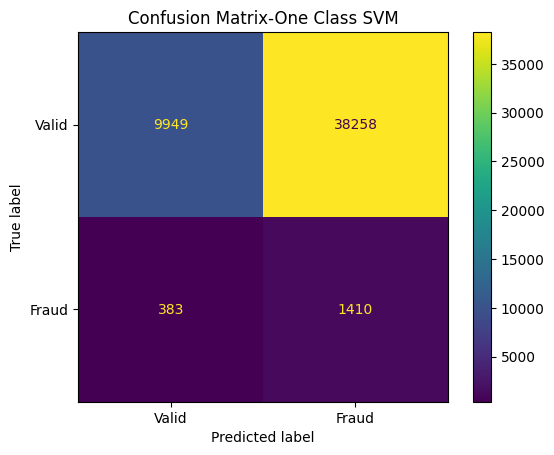

              precision    recall  f1-score   support

         0.0       0.96      0.21      0.34     48207
         1.0       0.04      0.79      0.07      1793

    accuracy                           0.23     50000
   macro avg       0.50      0.50      0.20     50000
weighted avg       0.93      0.23      0.33     50000



In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred_train)

# Displaying the confusion matrix using ConfusionMatrixDisplay
dispp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Valid', 'Fraud'])

dispp.plot()

plt.title("Confusion Matrix-One Class SVM")

plt.show()
print(classification_report(y_test, y_pred_train, zero_division=0))

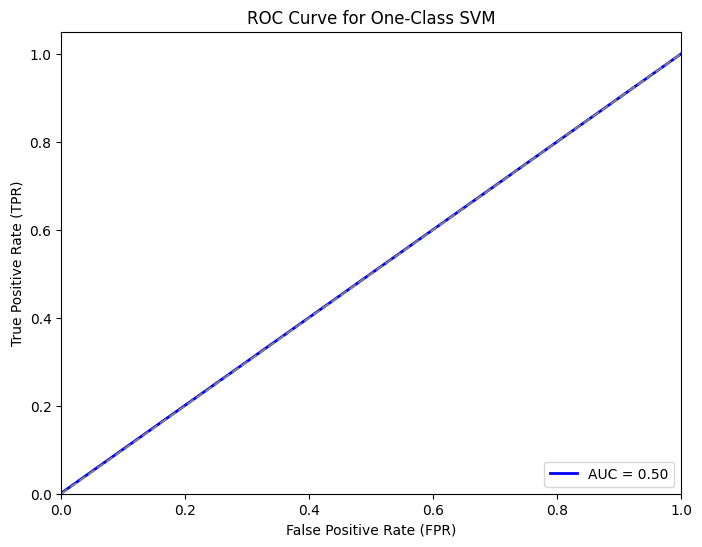

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.svm import OneClassSVM


# Predict the test data using the One-Class SVM model
y_score = clf.decision_function(X_test)

# Reshape y_score to 1D array
y_score = y_score.ravel()

# Calculate the false positive rate (FPR) and true positive rate (TPR) for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for One-Class SVM')
plt.legend(loc='lower right')
plt.show()
